## ResNet152 With pytorch
The architeccture of this will be provided in the documentation
For now we need to under stand the main things we need 
The choices of these tools are decided upon by the group members.

a. Model Compilation:

    Specify the optimizer (e.g., Adam), loss function (e.g., binary cross-entropy), and evaluation metrics (e.g., accuracy).

b. Training:

    Train the compiled model using the data generators.
    Provide code snippets for training the model using the Keras fit() function.

c. Performance Evaluation:

    Evaluate the trained model on the validation data.
    Specify the metrics used for evaluation (e.g., accuracy, precision, recall, ROC curves).

e. Results Analysis:

    Analyze the model's performance and make any necessary adjustments or improvements based on the results.

In [15]:
import matplotlib.pyplot as plt
import torchvision
import seaborn as sns
import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import cv2
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix, classification_report as skl_classification_report


In [3]:

def create_csv(data_dir, output_file):
    classes = ['Normal', 'Cataract']
    data = []

    for class_id, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            if img_name.endswith('.png'):
                img_path = os.path.join(class_dir, img_name)
                data.append([img_path, class_id])

    df = pd.DataFrame(data, columns=['img_path', 'label'])
    df.to_csv(output_file, index=False)
train_dir = "../data/train"
test_dir = "../data/test"


# Create CSV files for training and testing datasets
create_csv(train_dir, 'train.csv')
create_csv(test_dir, 'test.csv')


# Reading and Exploring the Data


Train size = 495
Test size = 121
                             img_path  label
0  ../data/train/Normal/image_101.png      0
1  ../data/train/Normal/image_141.png      0
2  ../data/train/Normal/image_233.png      0
3   ../data/train/Normal/image_39.png      0
4  ../data/train/Normal/image_189.png      0
                            img_path  label
0  ../data/test/Normal/image_298.png      0
1  ../data/test/Normal/image_282.png      0
2  ../data/test/Normal/image_257.png      0
3  ../data/test/Normal/image_248.png      0
4  ../data/test/Normal/image_273.png      0


/tmp/ipykernel_1352413/414525993.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), alpha=0.8, palette='bright')


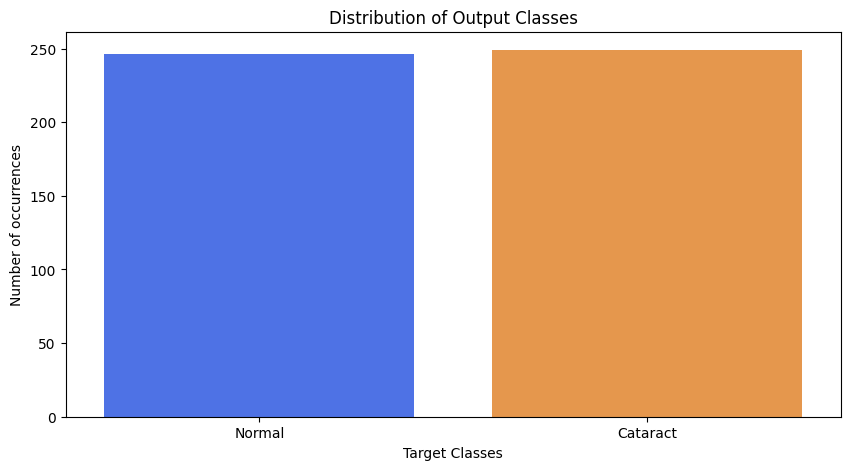

In [4]:
# Load CSV files
train_csv = pd.read_csv('train.csv')
test_csv = pd.read_csv('test.csv')

# Print lengths of CSV files
print('Train size = {}'.format(len(train_csv)))
print('Test size = {}'.format(len(test_csv)))

# Display initial values
print(train_csv.head())
print("========================================")
print(test_csv.head())

# Distribution of output classes
counts = train_csv['label'].value_counts()
class_list = ['Normal', 'Cataract']
counts = {class_list[i]: counts.get(i, 0) for i in range(len(class_list))}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(counts.keys()), y=list(counts.values()), alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of occurrences')
plt.xlabel('Target Classes')
plt.show()

# Visualizing the Data


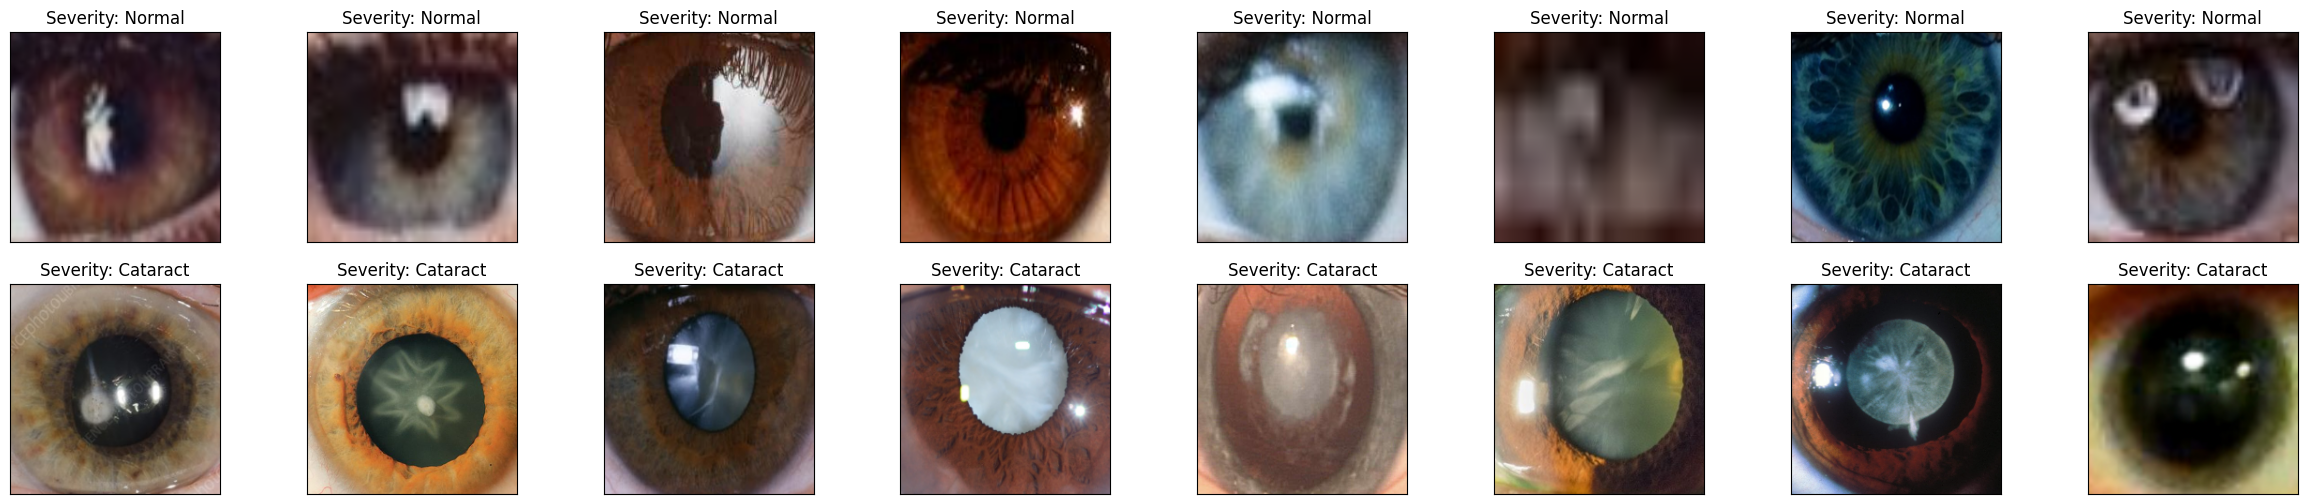

In [5]:
base_dir = '../data'

fig = plt.figure(figsize=(30, 6))

train_normal_dir = os.path.join(base_dir, 'train', 'Normal')
train_cataract_dir = os.path.join(base_dir, 'train', 'Cataract')

train_normal_imgs = os.listdir(train_normal_dir)
train_cataract_imgs = os.listdir(train_cataract_dir)

for idx, img in enumerate(np.random.choice(train_normal_imgs, 8)):
    ax = fig.add_subplot(2, 8, idx + 1, xticks=[], yticks=[])
    im = Image.open(os.path.join(train_normal_dir, img))
    plt.imshow(im)
    ax.set_title('Severity: Normal')

for idx, img in enumerate(np.random.choice(train_cataract_imgs, 8)):
    ax = fig.add_subplot(2, 8, idx + 9, xticks=[], yticks=[])
    im = Image.open(os.path.join(train_cataract_dir, img))
    plt.imshow(im)
    ax.set_title('Severity: Cataract')

plt.show()

# Data Processing

In [6]:
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir='../data', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name)
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_path = '../data/train/'
test_path = '../data/test/'

train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)

valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = DataLoader(train_data, batch_size=4, sampler=train_sampler)
validloader = DataLoader(train_data, batch_size=4, sampler=valid_sampler)
testloader = DataLoader(test_data, batch_size=4)

print(f'Training examples: {len(train_data)}')
print(f'Testing examples: {len(test_data)}')

print(len(trainloader))
print(len(validloader))
print(len(testloader))

Training examples: 495
Testing examples: 121
99
25
31


In [7]:
class CreateDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data.iloc[index, 0]
        label = int(self.data.iloc[index, 1])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_data = CreateDataset(csv_file='train.csv', transform=train_transforms)
test_data = CreateDataset(csv_file='test.csv', transform=test_transforms)

valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = DataLoader(train_data, batch_size=4, sampler=train_sampler)
validloader = DataLoader(train_data, batch_size=4, sampler=valid_sampler)
testloader = DataLoader(test_data, batch_size=4)

print(f'Training examples: {len(train_data)}')
print(f'Testing examples: {len(test_data)}')

Training examples: 495
Testing examples: 121


# Visualizing the Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Image shape: torch.Size([4, 3, 224, 224])
Label shape: torch.Size([4])
Labels: tensor([0, 0, 0, 1])


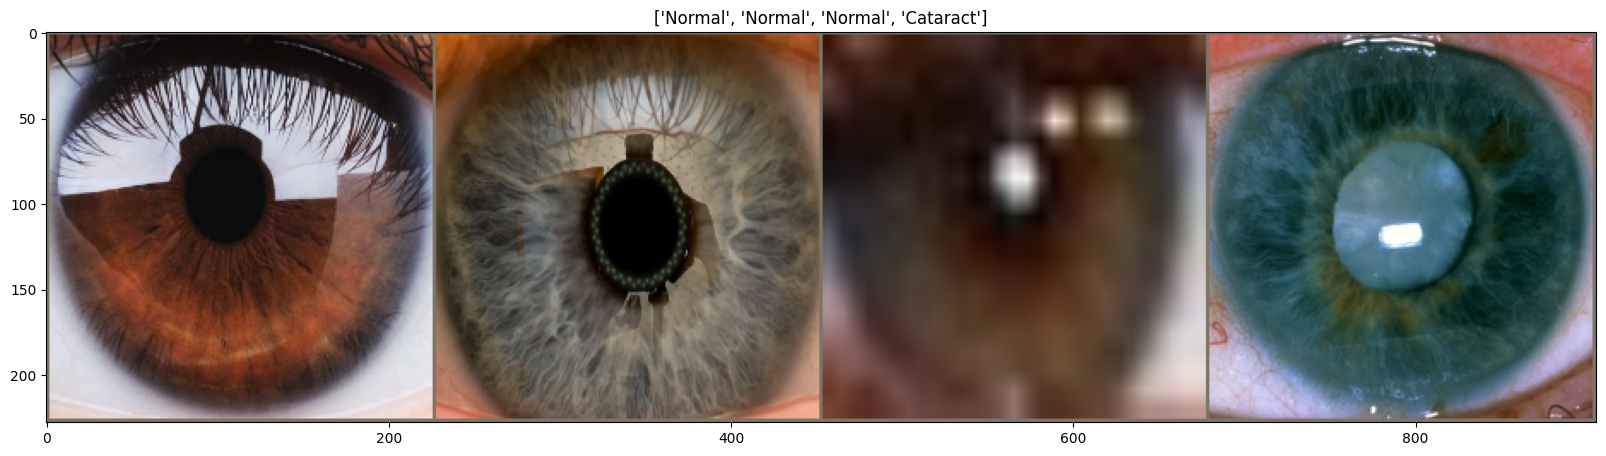

In [8]:
# Load one batch of the training set to check the images and their labels
images, labels = next(iter(trainloader))

# Checking the shape of the image
print(f'Image shape: {images.shape}')
print(f'Label shape: {labels.shape}')

# Denormalizing the images
def imshow(inp, title=None):
    """imshow for tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Plotting the images of loaded batch with given fig size and frame data
grid = torchvision.utils.make_grid(images, nrow=4, padding=2)
plt.figure(figsize=(20, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print('Labels:', labels)

class_names = ['Normal', 'Cataract']
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])


# Training and Validation

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is unfrozen
layer3 is frozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen
Number of trainable parameters: 
18354690
Model Training started......
Epoch 1 Batch 10 complete
Epoch 1 Batch 20 complete
Epoch 1 Batch 30 complete
Epoch 1 Batch 40 complete
Epoch 1 Batch 50 complete
Epoch 1 Batch 60 complete
Epoch 1 Batch 70 complete
Epoch 1 Batch 80 complete
Epoch 1 Batch 90 complete
Validation started for epoch 1
Epoch: 1/30.. Training Loss: 0.529.. Validation Loss: 0.337.. Validation Accuracy: 0.907
Validation loss decreased (inf --> 0.337025). Saving model...
Epoch 2 Batch 10 complete
Epoch 2 Batch 20 complete
Epoch 2 Batch 30 complete
Epoch 2 Batch 40 complete
Epoch 2 Batch 50 complete
Epoch 2 Batch 60 complete
Epoch 2 Batch 70 complete
Epoch 2 Batch 80 complete
Epoch 2 Batch 90 complete
Validation started for epoch 2
Epoch: 2/30.. Training Loss: 0.368.. Validation Loss: 0.196.. Validation Accurac

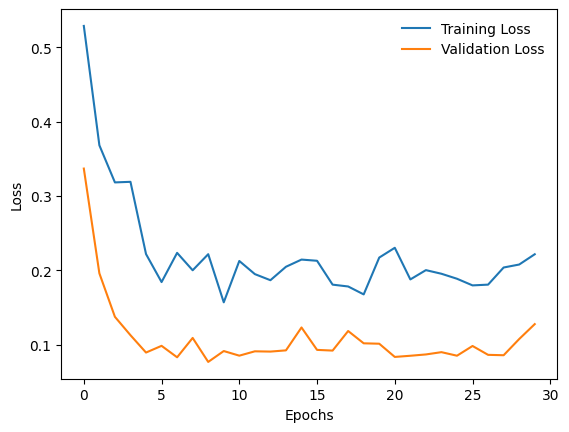

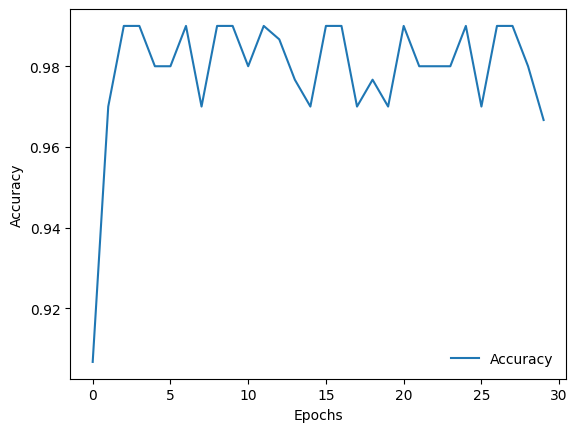

In [10]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet model
model = models.resnet152(pretrained=True)

# Modify the final layer
num_ftrs = model.fc.in_features
out_ftrs = 2  # Binary classification
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512), nn.ReLU(), nn.Linear(512, out_ftrs), nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

model.to(device)

model_save_name = 'classifier.pt'
model_save_path = f'./{model_save_name}'
torch.save(model.state_dict(), model_save_path)


# Unfreeze more layers for fine-tuning
for name, child in model.named_children():
    if name in ['layer2', 'layer4', 'fc']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False

def load_model(path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

def train_and_test(e):
    epochs = e
    train_losses, valid_losses, acc = [], [], []
    valid_loss_min = np.inf
    model.train()
    print("Model Training started......")
    for epoch in range(epochs):
        running_loss = 0
        batch = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch += 1
            if batch % 10 == 0:
                print(f'Epoch {epoch + 1} Batch {batch} complete')

        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            print(f'Validation started for epoch {epoch + 1}')
            model.eval()
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                logps = model(images)
                test_loss += criterion(logps, labels)
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss / len(trainloader))
        valid_losses.append(test_loss / len(validloader))
        acc.append(accuracy / len(validloader))
        scheduler.step()
        print(f'Epoch: {epoch + 1}/{epochs}.. Training Loss: {running_loss / len(trainloader):.3f}.. Validation Loss: {test_loss / len(validloader):.3f}.. Validation Accuracy: {accuracy / len(validloader):.3f}')

        model.train()
        if test_loss / len(validloader) <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {test_loss / len(validloader):.6f}). Saving model...')
            torch.save({
                'epoch': epoch,
                'model': model,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': valid_loss_min
            }, model_save_path)
            valid_loss_min = test_loss / len(validloader)

    print('Training completed successfully!')
    return train_losses, valid_losses, acc

train_losses, valid_losses, acc = train_and_test(30)

# Plot the graph for epochs
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

# Plot another graph for accuracy
plt.plot(acc, label='Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()


# Performance Evaluation

In [11]:
def evaluate_model(model, testloader):
    test_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            logps = model(images)
            test_loss += criterion(logps, labels)
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    test_loss = test_loss / len(testloader)
    accuracy = accuracy / len(testloader)
    print(f'Test Loss: {test_loss:.3f}.. Test Accuracy: {accuracy:.3f}')

evaluate_model(model, testloader)


Test Loss: 0.115.. Test Accuracy: 0.976


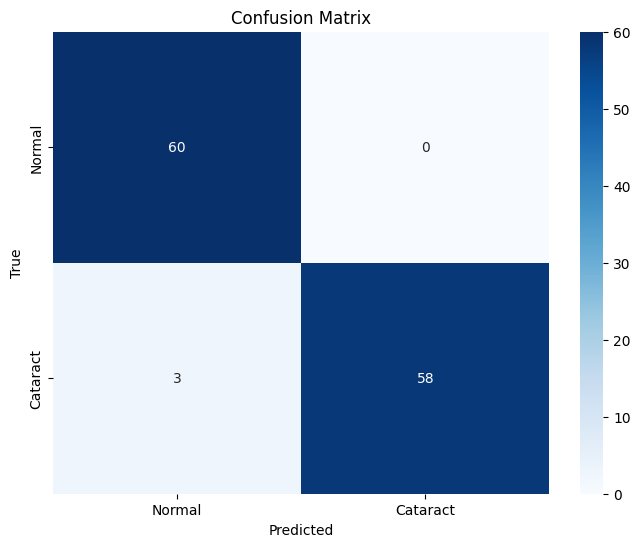

In [13]:
def plot_confusion_matrix(model, testloader):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Cataract'], yticklabels=['Normal', 'Cataract'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, testloader)

In [16]:
def print_classification_report(model, testloader):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    report = skl_classification_report(true_labels, pred_labels, target_names=['Normal', 'Cataract'])
    print(report)

print_classification_report(model, testloader)


              precision    recall  f1-score   support

      Normal       0.95      1.00      0.98        60
    Cataract       1.00      0.95      0.97        61

    accuracy                           0.98       121
   macro avg       0.98      0.98      0.98       121
weighted avg       0.98      0.98      0.98       121

